In [1]:
#import libraries

import pandas as pd
import numpy as np

from datetime import datetime, timedelta,date
from __future__ import division

%matplotlib inline
from sklearn.metrics import classification_report,confusion_matrix
import matplotlib.pyplot as plt

import seaborn as sns

import plotly as py
import plotly.offline as pyoff
import plotly.graph_objs as go

from sklearn.cluster import KMeans
import xgboost as xgb
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.cluster import KMeans

In [2]:
#Read data
data = pd.read_csv('TransactDataClean_3110.csv')
data.head()

,Invoice,StockCode,Quantity,InvoiceDate,Price,Customer ID,Country,Description
0,489434,85048,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,15CM CHRISTMAS GLASS BALL 20 LIGHTS
1,489434,79323P,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,PINK CHERRY LIGHTS
2,489434,79323W,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,WHITE CHERRY LIGHTS
3,489434,22041,48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,"RECORD FRAME 7"" SINGLE SIZE"
4,489434,21232,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,STRAWBERRY CERAMIC TRINKET BOX


In [3]:
# Removing rows with NA in Customer ID
cdata= data[data.isna()["Customer ID"]==0]
cdata.describe()

,Quantity,Price,Customer ID
count,812920.000000,812920.000000,812920.000000
mean,12.437772,2.976261,15329.690346
std,190.089978,4.552253,1694.981303
min,-80995.000000,0.000000,12346.000000
25%,2.000000,1.250000,13979.000000
50%,5.000000,1.950000,15265.000000
75%,12.000000,3.750000,16798.000000
max,80995.000000,649.500000,18287.000000


In [4]:
#adding year and month columns
cdata['InvoiceDate'] = pd.to_datetime(cdata['InvoiceDate'])
cdata['year'] = pd.DatetimeIndex(cdata['InvoiceDate']).year
cdata['month'] = pd.DatetimeIndex(cdata['InvoiceDate']).month

<ipython-input-4-7ded7a98d14e>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-4-7ded7a98d14e>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-4-7ded7a98d14e>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [5]:
cdata.head()

,Invoice,StockCode,Quantity,InvoiceDate,Price,Customer ID,Country,Description,year,month
0,489434,85048,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,15CM CHRISTMAS GLASS BALL 20 LIGHTS,2009,12
1,489434,79323P,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,PINK CHERRY LIGHTS,2009,12
2,489434,79323W,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,WHITE CHERRY LIGHTS,2009,12
3,489434,22041,48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,"RECORD FRAME 7"" SINGLE SIZE",2009,12
4,489434,21232,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,STRAWBERRY CERAMIC TRINKET BOX,2009,12


,Invoice,StockCode,Quantity,InvoiceDate,Price,Customer ID,Country,Description,year,month


In [29]:
#Creating monthly sales data 
vdata= cdata.copy()
vdata = vdata.loc[vdata['year']!=2009]
vdata["Revenue"]  = vdata["Price"] * vdata["Quantity"]
Monthly_sales=vdata.groupby(["Customer ID",'year','month']).agg({"Revenue":"sum"}).unstack(level=1).unstack(level=1)
Monthly_sales.columns = ["Jan-10","Feb-10","Mar-10","Apr-10","May-10","Jun-10","Jul-10","Aug-10","Sep-10","Oct-10","Nov-10","Dec-10","Jan-11","Feb-11","Mar-11","Apr-11","May-11","Jun-11","Jul-11","Aug-11","Sep-11","Oct-11","Nov-11","Dec-11"]
Monthly_sales.head()

,Jan-10,Feb-10,Mar-10,Apr-10,May-10,Jun-10,Jul-10,Aug-10,Sep-10,Oct-10,...,Mar-11,Apr-11,May-11,Jun-11,Jul-11,Aug-11,Sep-11,Oct-11,Nov-11,Dec-11
Customer ID,,,,,,,,,,,,,,,,,,,,,
12346.0,NaN,NaN,27.05,NaN,NaN,142.31,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12347.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,611.53,...,NaN,636.25,NaN,382.52,NaN,584.91,NaN,1258.62,NaN,224.82
12348.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,221.16,NaN,...,NaN,327.00,NaN,NaN,NaN,NaN,270.0,NaN,NaN,NaN
12349.0,NaN,NaN,NaN,1068.52,NaN,NaN,NaN,NaN,NaN,1152.62,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1457.55,NaN
12350.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
#filling  NAs with zero
Monthly_sales=Monthly_sales.fillna(value=0)
Monthly_sales[Monthly_sales.isnull().any(axis=1)]

,Jan-10,Feb-10,Mar-10,Apr-10,May-10,Jun-10,Jul-10,Aug-10,Sep-10,Oct-10,...,Mar-11,Apr-11,May-11,Jun-11,Jul-11,Aug-11,Sep-11,Oct-11,Nov-11,Dec-11
Customer ID,,,,,,,,,,,,,,,,,,,,,


In [35]:
#Final monthly data sheet output for Customer metrics UI
Monthly_sales.reset_index(inplace=True,drop= False)
#Monthly_sales.to_csv("Monthly_dummy_data.csv")
Monthly_sales

,Customer ID,Jan-10,Feb-10,Mar-10,Apr-10,May-10,Jun-10,Jul-10,Aug-10,Sep-10,...,Mar-11,Apr-11,May-11,Jun-11,Jul-11,Aug-11,Sep-11,Oct-11,Nov-11,Dec-11
0,12346.0,0.0,0.0,27.05,0.00,0.00,142.31,0.0,0.00,0.00,...,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00
1,12347.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.00,...,0.0,636.25,0.00,382.52,0.00,584.91,0.0,1258.62,0.00,224.82
2,12348.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.00,221.16,...,0.0,327.00,0.00,0.00,0.00,0.00,270.0,0.00,0.00,0.00
3,12349.0,0.0,0.0,0.00,1068.52,0.00,0.00,0.0,0.00,0.00,...,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.00,1457.55,0.00
4,12350.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.00,...,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5773,18283.0,0.0,98.4,235.27,0.00,0.00,0.00,0.0,92.00,0.00,...,0.0,115.73,99.47,286.88,140.24,0.00,130.9,114.65,651.56,208.00
5774,18284.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.00,...,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00
5775,18285.0,0.0,427.0,0.00,0.00,0.00,0.00,0.0,0.00,0.00,...,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00
5776,18286.0,0.0,0.0,0.00,0.00,0.00,-108.00,0.0,833.48,0.00,...,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00


# Pick data based on front end input

In [6]:
#Selecting data for analysis:
churn = True
Duration = 'six_months'

if Duration == 'six_months':
    Tpoint=pd.Timestamp(year=2011, month=6, day=1, hour=12) 
elif Duration == "one_year":
    Tpoint=pd.Timestamp(year=2010, month=12, day=1, hour=12) #Midpoint December 2010
elif Duration == 'two_year':
    Tpoint=pd.Timestamp(year=2009, month=12, day=1, hour=12)



#F2010=pd.Timestamp(year=Tpoint, month=12, day=1, hour=12) #Midpoint December 2010
if churn == False:
    Sdata = cdata[cdata["InvoiceDate"]>Tpoint ]
    Sdata = Sdata.reset_index(drop=True)
elif churn == True:
    Tpoint=pd.Timestamp(year=2011, month=6, day=1, hour=12)
    Sdata = cdata[cdata["InvoiceDate"]<Tpoint ]
    test = cdata[cdata["InvoiceDate"]>=Tpoint ]

In [7]:
Sdata.head()

,Invoice,StockCode,Quantity,InvoiceDate,Price,Customer ID,Country,Description,year,month
0,489434,85048,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,15CM CHRISTMAS GLASS BALL 20 LIGHTS,2009,12
1,489434,79323P,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,PINK CHERRY LIGHTS,2009,12
2,489434,79323W,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,WHITE CHERRY LIGHTS,2009,12
3,489434,22041,48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,"RECORD FRAME 7"" SINGLE SIZE",2009,12
4,489434,21232,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,STRAWBERRY CERAMIC TRINKET BOX,2009,12


# RECENCY

In [8]:
#create df with unique Customers
unique_users = pd.DataFrame(Sdata['Customer ID'].unique())
unique_users.columns = ['customer_ID']
unique_users.head()

,customer_ID
0,13085.0
1,13078.0
2,15362.0
3,18102.0
4,12682.0


In [9]:
unique_users

,customer_ID
0,13085.0
1,13078.0
2,15362.0
3,18102.0
4,12682.0
...,...
4928,15925.0
4929,16483.0
4930,15163.0
4931,18204.0


In [10]:
#Calculate what was the last date of purchase for the customers 

last_purchase = Sdata.groupby('Customer ID').agg({'InvoiceDate':'max'}).reset_index()
last_purchase.columns = ['customer_ID','last_transaction']
last_purchase.head()

,customer_ID,last_transaction
0,12346.0,2011-01-18 10:17:00
1,12347.0,2011-04-07 10:43:00
2,12348.0,2011-04-05 10:47:00
3,12349.0,2010-10-28 08:23:00
4,12350.0,2011-02-02 16:01:00


In [11]:
last_purchase['Recency'] = (last_purchase['last_transaction'].max() - last_purchase['last_transaction']).dt.days
last_purchase.head()
unique_users = pd.merge(unique_users, last_purchase[['customer_ID','Recency']], on='customer_ID')
unique_users.head()

,customer_ID,Recency
0,13085.0,33
1,13078.0,7
2,15362.0,257
3,18102.0,15
4,12682.0,0


In [12]:
# check if all customers have been assigned Recency
unique_users[unique_users.isna()["Recency"]!=0]

,customer_ID,Recency


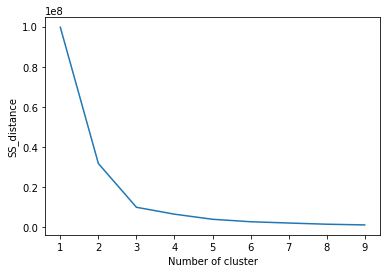

In [13]:
# Creating an Elbow diagram to find what number of clusters are suitable
error=[]
clusters = []

for k in range(1, 10):
    clf = KMeans(n_clusters=k, random_state=3, max_iter=1000).fit(unique_users[['Recency']])
    error+= [clf.inertia_]   #Sum of squared distances of samples to their closest cluster center
    clusters += [k]
plt.figure()
plt.plot(clusters, error)
plt.ylabel("SS_distance")
plt.xlabel("Number of cluster")
plt.show()


In [14]:
#fitting the model based on above findings
k=3
clf = KMeans(n_clusters=k,random_state=3, max_iter=1000).fit(unique_users[['Recency']])
unique_users['R_cluster'] = clf.labels_
unique_users.head()

,customer_ID,Recency,R_cluster
0,13085.0,33,0
1,13078.0,7,0
2,15362.0,257,2
3,18102.0,15,0
4,12682.0,0,0


In [15]:
len(unique_users)

4933

In [16]:
len(unique_users.loc[unique_users["R_cluster"]==0])

2378

In [17]:
unique_users.groupby('R_cluster')['Recency'].describe()

,count,mean,std,min,25%,50%,75%,max
R_cluster,,,,,,,,
0,2378.0,46.931455,36.645557,0.0,14.0,41.0,72.0,131.0
1,791.0,421.855879,67.397532,319.0,363.5,412.0,473.5,547.0
2,1764.0,215.086735,42.297247,132.0,184.0,208.0,240.0,318.0


In [18]:
# Ordering the clusters based on mean of centers
#finding the mean of cluster and sorting it
df_new = unique_users.groupby('R_cluster').agg({'Recency':'mean'}).reset_index().sort_values(by='Recency',ascending=False).reset_index(drop=True)  
# New colum order is ordered cluster
df_new['order'] = df_new.index
df_new = df_new.loc[:,['R_cluster','order']]

#Merge with Unique Users cluster and keep the ordered cluster
unique_users = unique_users.merge(df_new, on='R_cluster', how='left', sort=False)
unique_users = unique_users.drop(['R_cluster'],axis=1)
unique_users = unique_users.rename(columns={"order":'R_cluster'})
unique_users.head()

,customer_ID,Recency,R_cluster
0,13085.0,33,2
1,13078.0,7,2
2,15362.0,257,1
3,18102.0,15,2
4,12682.0,0,2


In [19]:
unique_users.groupby('R_cluster')['Recency'].describe()

,count,mean,std,min,25%,50%,75%,max
R_cluster,,,,,,,,
0,791.0,421.855879,67.397532,319.0,363.5,412.0,473.5,547.0
1,1764.0,215.086735,42.297247,132.0,184.0,208.0,240.0,318.0
2,2378.0,46.931455,36.645557,0.0,14.0,41.0,72.0,131.0


# Frequency

In [20]:
buy_frequency = Sdata.groupby('Customer ID').agg({'InvoiceDate':'count'}).reset_index()
buy_frequency.columns = ['customer_ID','Freq']
buy_frequency.head()

,customer_ID,Freq
0,12346.0,26
1,12347.0,155
2,12348.0,44
3,12349.0,105
4,12350.0,16


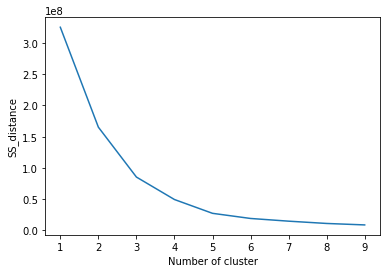

In [21]:
# Creating an Elbow diagram to find what number of clusters are suitable
error=[]
clusters = []

for k in range(1, 10):
    clf = KMeans(n_clusters=k, random_state=3, max_iter=1000).fit(buy_frequency[['Freq']])
    error+= [clf.inertia_]   #Sum of squared distances of samples to their closest cluster center
    clusters += [k]
plt.figure()
plt.plot(clusters, error)
plt.ylabel("SS_distance")
plt.xlabel("Number of cluster")
plt.show()

In [22]:
#fitting the model based on above findings
k=4
clf = KMeans(n_clusters=k,random_state=3, max_iter=1000).fit(buy_frequency[['Freq']])
buy_frequency['F_cluster'] = clf.labels_
buy_frequency.head()

,customer_ID,Freq,F_cluster
0,12346.0,26,1
1,12347.0,155,1
2,12348.0,44,1
3,12349.0,105,1
4,12350.0,16,1


In [23]:
buy_frequency.groupby('F_cluster')['Freq'].describe()

,count,mean,std,min,25%,50%,75%,max
F_cluster,,,,,,,,
0,399.0,520.596491,232.728420,294.0,356.0,433.0,612.0,1474.0
1,4518.0,65.960602,66.453582,1.0,17.0,41.0,92.0,293.0
2,3.0,6564.333333,1108.426512,5285.0,6228.0,7171.0,7204.0,7237.0
3,13.0,2510.076923,671.197371,1811.0,2002.0,2277.0,2738.0,3991.0


In [24]:
# Ordering the clusters based on mean of centers
#finding the mean of cluster and sorting it
df_new = buy_frequency.groupby('F_cluster').agg({'Freq':'mean'}).reset_index().sort_values(by='Freq',ascending=True).reset_index(drop=True)  

# New colum order is ordered cluster
df_new['order'] = df_new.index
df_new = df_new.loc[:,['F_cluster','order']]

#Merge with Unique Users cluster and keep the ordered cluster
buy_frequency = buy_frequency.merge(df_new, on='F_cluster', how='left', sort=False)
buy_frequency = buy_frequency.drop(['F_cluster'],axis=1)
buy_frequency = buy_frequency.rename(columns={"order":'F_cluster'})
buy_frequency.head()

,customer_ID,Freq,F_cluster
0,12346.0,26,0
1,12347.0,155,0
2,12348.0,44,0
3,12349.0,105,0
4,12350.0,16,0


In [25]:
buy_frequency.groupby('F_cluster')['Freq'].describe()

,count,mean,std,min,25%,50%,75%,max
F_cluster,,,,,,,,
0,4518.0,65.960602,66.453582,1.0,17.0,41.0,92.0,293.0
1,399.0,520.596491,232.728420,294.0,356.0,433.0,612.0,1474.0
2,13.0,2510.076923,671.197371,1811.0,2002.0,2277.0,2738.0,3991.0
3,3.0,6564.333333,1108.426512,5285.0,6228.0,7171.0,7204.0,7237.0


# Monetary value

In [26]:
#calculate revenue for every customerid
Sdata['Revenue'] = Sdata['Price'] * Sdata['Quantity']
cus_revenue = Sdata.groupby('Customer ID').agg({'Revenue':'sum'}).reset_index()
cus_revenue.columns = ['customer_ID','Revenue']
cus_revenue.head()

<ipython-input-26-cc6f039accdd>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,customer_ID,Revenue
0,12346.0,169.36
1,12347.0,3146.75
2,12348.0,1388.40
3,12349.0,2196.99
4,12350.0,294.40


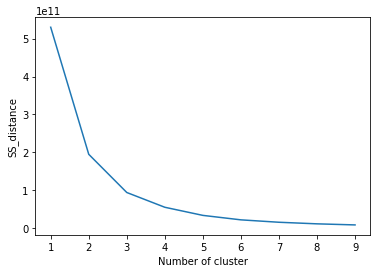

In [27]:
# Creating an Elbow diagram to find what number of clusters are suitable
error=[]
clusters = []

for k in range(1, 10):
    clf = KMeans(n_clusters=k, random_state=3, max_iter=1000).fit(cus_revenue[['Revenue']])
    error+= [clf.inertia_]   #Sum of squared distances of samples to their closest cluster center
    clusters += [k]
plt.figure()
plt.plot(clusters, error)
plt.ylabel("SS_distance")
plt.xlabel("Number of cluster")
plt.show()

In [28]:
#fitting the model based on above findings
k=4
clf = KMeans(n_clusters=k,random_state=3, max_iter=1000).fit(cus_revenue[['Revenue']])
cus_revenue['M_cluster'] = clf.labels_
cus_revenue.head()

,customer_ID,Revenue,M_cluster
0,12346.0,169.36,0
1,12347.0,3146.75,0
2,12348.0,1388.40,0
3,12349.0,2196.99,0
4,12350.0,294.40,0


In [29]:
cus_revenue.groupby('M_cluster')['Revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
M_cluster,,,,,,,,
0,4862.0,1550.586368,2253.789204,-1663.06,299.865,710.490,1777.7475,16578.26
1,7.0,138500.197143,46756.378405,95448.76,106383.160,115789.770,160109.1800,225278.17
2,2.0,379570.590000,41941.543751,349913.44,364742.015,379570.590,394399.1650,409227.74
3,62.0,32655.636935,16138.647733,17168.39,21219.915,25899.315,40209.7650,82267.00


In [30]:
# Ordering the clusters based on mean of centers
#finding the mean of cluster and sorting it
df_new = cus_revenue.groupby('M_cluster').agg({'Revenue':'mean'}).reset_index().sort_values(by='Revenue',ascending=True).reset_index(drop=True)  

# New colum order is ordered cluster
df_new['order'] = df_new.index
df_new = df_new.loc[:,['M_cluster','order']]

#Merge with Unique Users cluster and keep the ordered cluster
cus_revenue = cus_revenue.merge(df_new, on='M_cluster', how='left', sort=False)
cus_revenue = cus_revenue.drop(['M_cluster'],axis=1)
cus_revenue = cus_revenue.rename(columns={"order":'M_cluster'})
cus_revenue.head()

,customer_ID,Revenue,M_cluster
0,12346.0,169.36,0
1,12347.0,3146.75,0
2,12348.0,1388.40,0
3,12349.0,2196.99,0
4,12350.0,294.40,0


In [31]:
cus_revenue.groupby('M_cluster')['Revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
M_cluster,,,,,,,,
0,4862.0,1550.586368,2253.789204,-1663.06,299.865,710.490,1777.7475,16578.26
1,62.0,32655.636935,16138.647733,17168.39,21219.915,25899.315,40209.7650,82267.00
2,7.0,138500.197143,46756.378405,95448.76,106383.160,115789.770,160109.1800,225278.17
3,2.0,379570.590000,41941.543751,349913.44,364742.015,379570.590,394399.1650,409227.74


# RFM SCORE

In [32]:
# Merge all the RFM's 
#unique_users cus_revenue buy_frequency
unique_users_m = unique_users.merge(buy_frequency, on='customer_ID', how='left', sort=False)
unique_users_m = unique_users_m.merge(cus_revenue, on='customer_ID', how='left', sort=False)
weight_R = 0.3
weight_F = 0.4
weight_M = 1- weight_R-weight_F
#calculate score
unique_users_m['RFM_Score'] = unique_users_m['R_cluster'] +  unique_users_m['F_cluster'] + unique_users_m['M_cluster']
unique_users_m.groupby('RFM_Score')['Recency','Freq','Revenue'].mean()

<ipython-input-32-6d6470f8bef1>:10: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



,Recency,Freq,Revenue
RFM_Score,,,
0,422.067344,27.833545,459.518374
1,216.120510,57.136732,904.843360
2,53.087321,95.064628,1829.282407
3,32.233918,492.818713,7567.347982
4,18.848485,758.454545,29362.411515
5,18.583333,2089.916667,73839.255833
6,7.750000,4089.500000,174857.720000
7,2.500000,4911.500000,259196.195000


In [33]:
unique_users_m.head()

,customer_ID,Recency,R_cluster,Freq,F_cluster,Revenue,M_cluster,RFM_Score
0,13085.0,33,2,82,0,2151.60,0,2
1,13078.0,7,2,636,1,19982.06,1,4
2,15362.0,257,1,40,0,613.08,0,1
3,18102.0,15,2,707,1,409227.74,3,6
4,12682.0,0,2,719,1,15296.88,0,3


In [34]:
unique_users_m

,customer_ID,Recency,R_cluster,Freq,F_cluster,Revenue,M_cluster,RFM_Score
0,13085.0,33,2,82,0,2151.60,0,2
1,13078.0,7,2,636,1,19982.06,1,4
2,15362.0,257,1,40,0,613.08,0,1
3,18102.0,15,2,707,1,409227.74,3,6
4,12682.0,0,2,719,1,15296.88,0,3
...,...,...,...,...,...,...,...,...
4928,15925.0,2,2,12,0,207.15,0,2
4929,16483.0,0,2,19,0,139.35,0,2
4930,15163.0,0,2,10,0,155.00,0,2
4931,18204.0,0,2,93,0,549.43,0,2


# Churn Probability

In [35]:
# Adding features - RFM
churn_data=unique_users_m.loc[:,['customer_ID','Recency','Freq','Revenue']]
churn_data

,customer_ID,Recency,Freq,Revenue
0,13085.0,33,82,2151.60
1,13078.0,7,636,19982.06
2,15362.0,257,40,613.08
3,18102.0,15,707,409227.74
4,12682.0,0,719,15296.88
...,...,...,...,...
4928,15925.0,2,12,207.15
4929,16483.0,0,19,139.35
4930,15163.0,0,10,155.00
4931,18204.0,0,93,549.43


### 1) Adding Price per unit as feature

In [36]:
# Adding features - Price per unit
data = Sdata.groupby('Customer ID').agg({'Price':'mean'}).reset_index() # premium products
data.columns = ['customer_ID','price_per_unit']
churn_data = churn_data.merge(data, on='customer_ID', how='left', sort=False)

In [37]:
data[data.isna()["price_per_unit"]!=0]

,customer_ID,price_per_unit


In [38]:
churn_data.head()


,customer_ID,Recency,Freq,Revenue,price_per_unit
0,13085.0,33,82,2151.60,3.226220
1,13078.0,7,636,19982.06,4.112925
2,15362.0,257,40,613.08,3.612000
3,18102.0,15,707,409227.74,3.789024
4,12682.0,0,719,15296.88,2.915828


### 2) Adding top products as features

In [39]:
#Sdata['StockCode'] = pd.to_numeric(Sdata['StockCode'])
cdata['Revenue'] = cdata['Price'] * cdata['Quantity']
products = cdata.groupby('StockCode').agg({'Revenue':'sum','Quantity':'sum','Invoice':'count'}).reset_index().sort_values(by='Invoice',ascending=False).reset_index(drop=True)
products.columns = ['StockCode','Revenue','Quantity','Frequency']
products.head()

,StockCode,Revenue,Quantity,Frequency
0,22423,269736.70,23446,3777
1,85099B,168440.36,93766,3446
2,84879,126354.18,79434,2794
3,20725,58925.90,37406,2755
4,21212,43570.48,90249,2679


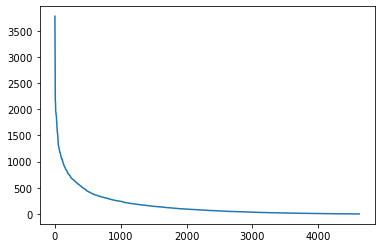

In [40]:
plt.figure()
plt.plot(products.index, products.Frequency)
plt.ylabel("")
plt.xlabel("")
plt.show()

In [41]:
# using frequency (invoice count) as selection criteria
top5 = list(products.StockCode[0:5])
top5_20 = list(products.StockCode[5:20])
top20_35 = list(products.StockCode[20:35])

In [42]:
# adding as criteria
#df.isin({'num_wings': [0, 3]})
chk = Sdata.loc[:,["Customer ID",'StockCode']]
chk.columns = ['customer_ID','StockCode']

#for top 5
chk["product_top5"] = chk["StockCode"].isin(top5)
tst=chk.groupby('customer_ID').agg({'product_top5':'max'}).reset_index()
churn_data = churn_data.merge(tst, on='customer_ID', how='left', sort=False)

#for top 5_20
chk["product_top5_20"] = chk["StockCode"].isin(top5_20)
tst=chk.groupby('customer_ID').agg({'product_top5_20':'max'}).reset_index()
churn_data = churn_data.merge(tst, on='customer_ID', how='left', sort=False)

In [43]:
churn_data.head()

,customer_ID,Recency,Freq,Revenue,price_per_unit,product_top5,product_top5_20
0,13085.0,33,82,2151.60,3.226220,False,True
1,13078.0,7,636,19982.06,4.112925,True,True
2,15362.0,257,40,613.08,3.612000,False,True
3,18102.0,15,707,409227.74,3.789024,True,True
4,12682.0,0,719,15296.88,2.915828,True,True


In [44]:
#add the country as feature
tst=Sdata.groupby('Customer ID').agg({'Country':'max'}).reset_index()
tst.columns = ['customer_ID','Country']
churn_data = churn_data.merge(tst, on='customer_ID', how='left', sort=False)
churn_data.head()

,customer_ID,Recency,Freq,Revenue,price_per_unit,product_top5,product_top5_20,Country
0,13085.0,33,82,2151.60,3.226220,False,True,United Kingdom
1,13078.0,7,636,19982.06,4.112925,True,True,United Kingdom
2,15362.0,257,40,613.08,3.612000,False,True,United Kingdom
3,18102.0,15,707,409227.74,3.789024,True,True,United Kingdom
4,12682.0,0,719,15296.88,2.915828,True,True,France


### 3) Adding churn as Y element

In [45]:
test.head()

,Invoice,StockCode,Quantity,InvoiceDate,Price,Customer ID,Country,Description,year,month
717518,555200,21035,1,2011-06-01 12:05:00,3.25,17315.0,United Kingdom,SET/2 RED RETROSPOT TEA TOWELS,2011,6
717519,555200,47566,12,2011-06-01 12:05:00,4.95,17315.0,United Kingdom,PARTY BUNTING,2011,6
717520,555200,21894,10,2011-06-01 12:05:00,1.25,17315.0,United Kingdom,POTTING SHED SEED ENVELOPES,2011,6
717521,555200,21792,3,2011-06-01 12:05:00,3.95,17315.0,United Kingdom,CLASSIC FRENCH STYLE BASKET GREEN,2011,6
717522,555200,22151,48,2011-06-01 12:05:00,0.42,17315.0,United Kingdom,PLACE SETTING WHITE HEART,2011,6


In [46]:
Customer_not_left= list(test['Customer ID'].unique())
churn_data["Y_churn"]=~churn_data["customer_ID"].isin(Customer_not_left)
churn_data.head()

,customer_ID,Recency,Freq,Revenue,price_per_unit,product_top5,product_top5_20,Country,Y_churn
0,13085.0,33,82,2151.60,3.226220,False,True,United Kingdom,False
1,13078.0,7,636,19982.06,4.112925,True,True,United Kingdom,False
2,15362.0,257,40,613.08,3.612000,False,True,United Kingdom,True
3,18102.0,15,707,409227.74,3.789024,True,True,United Kingdom,False
4,12682.0,0,719,15296.88,2.915828,True,True,France,False


In [47]:
churn_data

,customer_ID,Recency,Freq,Revenue,price_per_unit,product_top5,product_top5_20,Country,Y_churn
0,13085.0,33,82,2151.60,3.226220,False,True,United Kingdom,False
1,13078.0,7,636,19982.06,4.112925,True,True,United Kingdom,False
2,15362.0,257,40,613.08,3.612000,False,True,United Kingdom,True
3,18102.0,15,707,409227.74,3.789024,True,True,United Kingdom,False
4,12682.0,0,719,15296.88,2.915828,True,True,France,False
...,...,...,...,...,...,...,...,...,...
4928,15925.0,2,12,207.15,2.895833,True,False,United Kingdom,True
4929,16483.0,0,19,139.35,4.410526,False,True,United Kingdom,True
4930,15163.0,0,10,155.00,3.205000,False,True,United Kingdom,False
4931,18204.0,0,93,549.43,2.223871,False,True,United Kingdom,False


# Pycaret set up

In [48]:
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin'
from pycaret.classification import *

In [49]:
s = setup(churn_data, target = 'Y_churn',ignore_features = ['customer_ID'])

,Description,Value
0,session_id,3385
1,Target,Y_churn
2,Target Type,Binary
3,Label Encoded,"False: 0, True: 1"
4,Original Data,"(4933, 9)"
5,Missing Values,False
6,Numeric Features,4
7,Categorical Features,3
8,Ordinal Features,False
9,High Cardinality Features,False


In [50]:
best_model = compare_models(sort='Accuracy')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.7318,0.8073,0.7252,0.7072,0.7158,0.4620,0.4625,0.0840
catboost,CatBoost Classifier,0.7301,0.8055,0.7289,0.7036,0.7155,0.4589,0.4598,0.7580
lightgbm,Light Gradient Boosting Machine,0.7208,0.7943,0.7165,0.6956,0.7053,0.4403,0.4411,0.1290
ada,Ada Boost Classifier,0.7173,0.7968,0.6991,0.6974,0.6971,0.4322,0.4335,0.0370
lr,Logistic Regression,0.7165,0.7981,0.6793,0.7037,0.6909,0.4292,0.4298,0.3320
rf,Random Forest Classifier,0.7162,0.7928,0.6985,0.6949,0.6962,0.4300,0.4306,0.0890
lda,Linear Discriminant Analysis,0.7133,0.7872,0.6358,0.7183,0.6740,0.4199,0.4228,0.0090
ridge,Ridge Classifier,0.7130,0.0000,0.6346,0.7183,0.6733,0.4192,0.4222,0.0070
xgboost,Extreme Gradient Boosting,0.7046,0.7830,0.6998,0.6783,0.6884,0.4078,0.4085,0.1290
et,Extra Trees Classifier,0.7043,0.7787,0.6768,0.6862,0.6808,0.4055,0.4062,0.0970


In [51]:
print(best_model)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=3385, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)


In [52]:
tuned_best_model = tune_model(best_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7370,0.8022,0.7081,0.7215,0.7147,0.4708,0.4709
1,0.7283,0.8066,0.7407,0.6977,0.7186,0.4564,0.4572
2,0.7428,0.8167,0.6975,0.7386,0.7175,0.4817,0.4824
3,0.7565,0.8463,0.7267,0.7452,0.7358,0.5101,0.5102
4,0.7101,0.7779,0.6522,0.7047,0.6774,0.4150,0.4160
5,0.7304,0.8006,0.7143,0.7099,0.7121,0.4587,0.4587
6,0.7014,0.7801,0.6770,0.6812,0.6791,0.4000,0.4000
7,0.7652,0.8263,0.7888,0.7299,0.7582,0.5307,0.5322
8,0.7014,0.7811,0.7019,0.6726,0.6869,0.4019,0.4022
9,0.7043,0.7992,0.6708,0.6879,0.6792,0.4051,0.4052


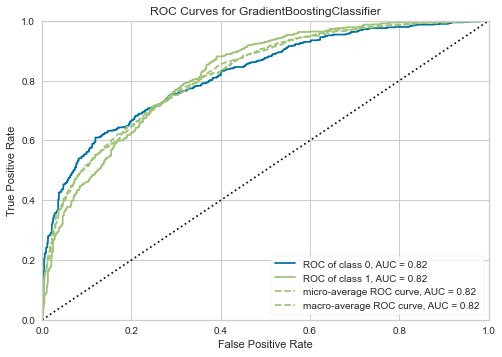

In [53]:
plot_model(tuned_best_model, plot = 'auc')

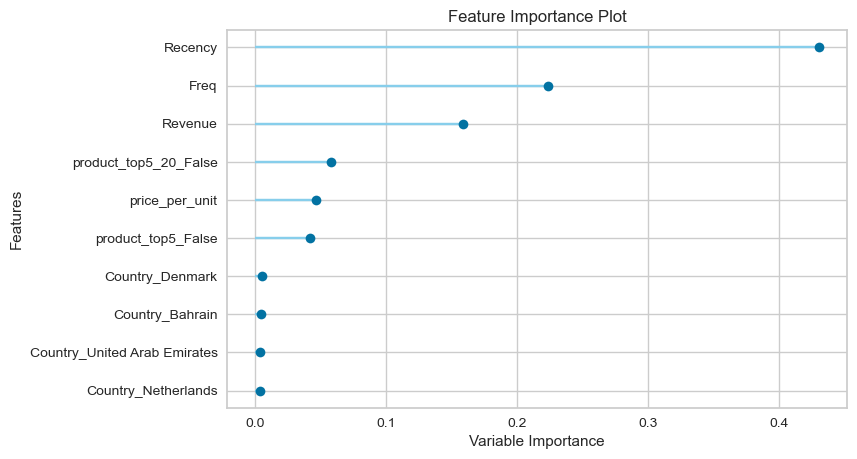

In [54]:
plot_model(tuned_best_model, plot = 'feature')

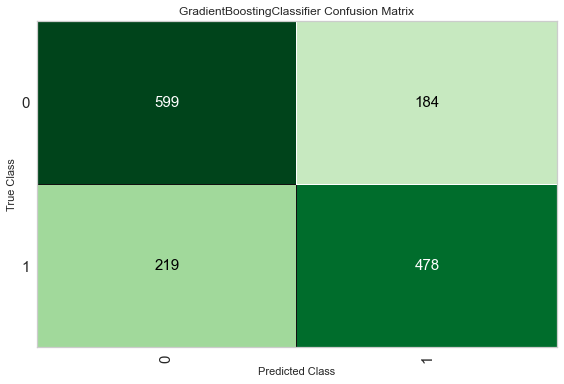

In [55]:
plot_model(tuned_best_model, plot = 'confusion_matrix')

In [56]:
#opportunity cost - function

#cost of retaining: 10 , profit from retaining 50
def opportunity_cost (y, y_pred):
    true_postive = np.where((y_pred==1) & (y==1), (50-10), 0)
    false_posive = np.where((y_pred==1) & (y==0), -10, 0)
    #false_negative = np.where((y_pred==0) & (y==1), -20, 0)
    return np.sum([true_postive,false_posive])

#add to PyCaret
add_metric('profit', 'Profit', opportunity_cost)

Name                                                            Profit
Display Name                                                    Profit
Score Function       <function opportunity_cost at 0x00000247D4EE3A60>
Scorer                                   make_scorer(opportunity_cost)
Target                                                            pred
Args                                                                {}
Greater is Better                                                 True
Multiclass                                                        True
Custom                                                            True
Name: profit, dtype: object

In [57]:
# fit the models again
best_model = compare_models(sort='Profit')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Profit,TT (Sec)
nb,Naive Bayes,0.5937,0.7852,0.9677,0.5361,0.6899,0.2228,0.3204,4889.0000,0.0080
catboost,CatBoost Classifier,0.7301,0.8055,0.7289,0.7036,0.7155,0.4589,0.4598,4205.0000,0.6990
gbc,Gradient Boosting Classifier,0.7318,0.8073,0.7252,0.7072,0.7158,0.4620,0.4625,4193.0000,0.0850
lightgbm,Light Gradient Boosting Machine,0.7208,0.7943,0.7165,0.6956,0.7053,0.4403,0.4411,4113.0000,0.0850
ada,Ada Boost Classifier,0.7173,0.7968,0.6991,0.6974,0.6971,0.4322,0.4335,4017.0000,0.0380
rf,Random Forest Classifier,0.7162,0.7928,0.6985,0.6949,0.6962,0.4300,0.4306,4010.0000,0.0950
xgboost,Extreme Gradient Boosting,0.7046,0.7830,0.6998,0.6783,0.6884,0.4078,0.4085,3976.0000,0.1290
lr,Logistic Regression,0.7165,0.7981,0.6793,0.7037,0.6909,0.4292,0.4298,3918.0000,0.0190
et,Extra Trees Classifier,0.7043,0.7787,0.6768,0.6862,0.6808,0.4055,0.4062,3864.0000,0.0950
knn,K Neighbors Classifier,0.6913,0.7501,0.6625,0.6716,0.6664,0.3792,0.3797,3750.0000,0.0160


In [58]:
tuned_best_model = tune_model(best_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Profit
0,0.5983,0.7808,0.9876,0.5372,0.6958,0.2343,0.3505,4990.0000
1,0.5925,0.7902,0.9753,0.5356,0.6915,0.2199,0.3248,4950.0000
2,0.5925,0.7997,0.9753,0.5356,0.6915,0.2199,0.3248,4950.0000
3,0.5797,0.8364,0.9689,0.5270,0.6827,0.1977,0.2974,4840.0000
4,0.5507,0.7728,0.9503,0.5100,0.6638,0.1436,0.2243,4650.0000
5,0.5942,0.7800,0.9752,0.5358,0.6916,0.2245,0.3291,4920.0000
6,0.5884,0.7526,0.9627,0.5326,0.6858,0.2129,0.3070,4840.0000
7,0.6087,0.8119,0.9876,0.5445,0.7020,0.2519,0.3663,5030.0000
8,0.6000,0.7712,0.9565,0.5404,0.6906,0.2333,0.3219,4850.0000
9,0.6232,0.7834,0.9689,0.5552,0.7059,0.2767,0.3717,4990.0000


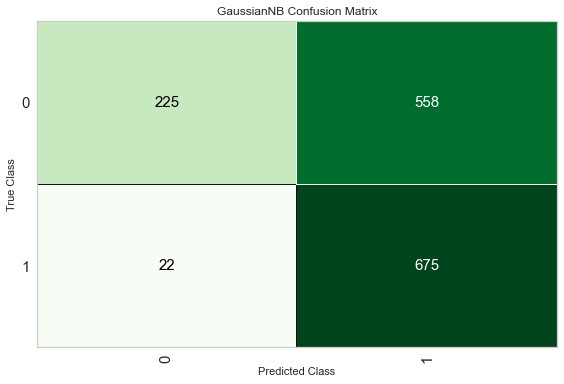

In [59]:
plot_model(best_model, plot = 'confusion_matrix')

In [60]:
print(tuned_best_model)

GaussianNB(priors=None, var_smoothing=2e-09)


In [62]:
#plot_model(tuned_best_model, plot = 'feature')

In [63]:
# training the selected model and predicting teh probability
model_gbc = create_model('gbc')
pred_probability = predict_model(model_gbc,data = churn_data)
pred_probability

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Profit
0,0.7572,0.8040,0.7578,0.7305,0.7439,0.5133,0.5136,4430.0000
1,0.7457,0.8073,0.7654,0.7126,0.7381,0.4915,0.4927,4460.0000
2,0.7254,0.8261,0.6975,0.7107,0.7040,0.4480,0.4481,4060.0000
3,0.7478,0.8390,0.7329,0.7284,0.7307,0.4936,0.4936,4280.0000
4,0.7246,0.7975,0.7081,0.7037,0.7059,0.4470,0.4470,4080.0000
5,0.7304,0.7975,0.7205,0.7073,0.7138,0.4591,0.4592,4160.0000
6,0.6928,0.7767,0.6708,0.6708,0.6708,0.3828,0.3828,3790.0000
7,0.7855,0.8367,0.8137,0.7486,0.7798,0.5714,0.5733,4800.0000
8,0.7130,0.7877,0.7267,0.6802,0.7027,0.4260,0.4268,4130.0000
9,0.6957,0.8009,0.6584,0.6795,0.6688,0.3874,0.3876,3740.0000


,customer_ID,Recency,Freq,Revenue,price_per_unit,product_top5,product_top5_20,Country,Y_churn,Label,Score
0,13085.0,33,82,2151.60,3.226220,False,True,United Kingdom,False,False,0.8666
1,13078.0,7,636,19982.06,4.112925,True,True,United Kingdom,False,False,0.9614
2,15362.0,257,40,613.08,3.612000,False,True,United Kingdom,True,True,0.5355
3,18102.0,15,707,409227.74,3.789024,True,True,United Kingdom,False,False,0.9721
4,12682.0,0,719,15296.88,2.915828,True,True,France,False,False,0.9703
...,...,...,...,...,...,...,...,...,...,...,...
4928,15925.0,2,12,207.15,2.895833,True,False,United Kingdom,True,False,0.5147
4929,16483.0,0,19,139.35,4.410526,False,True,United Kingdom,True,True,0.7288
4930,15163.0,0,10,155.00,3.205000,False,True,United Kingdom,False,False,0.5479
4931,18204.0,0,93,549.43,2.223871,False,True,United Kingdom,False,False,0.7552


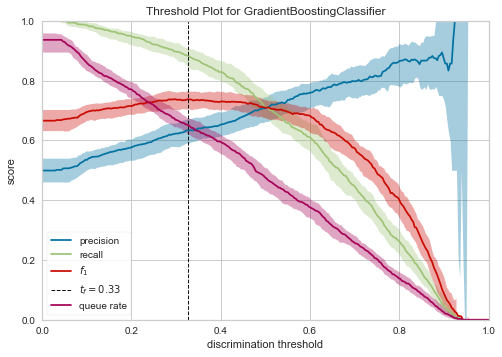

In [77]:
plot_model(model_gbc, plot = 'threshold')

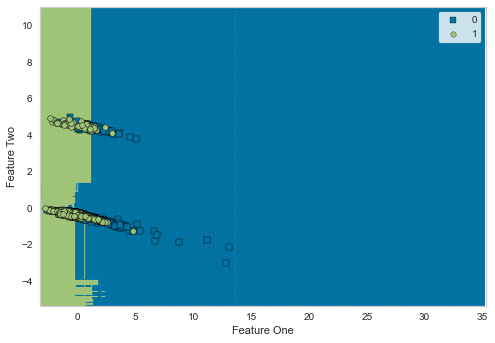

In [78]:
plot_model(model_gbc, plot = 'boundary')

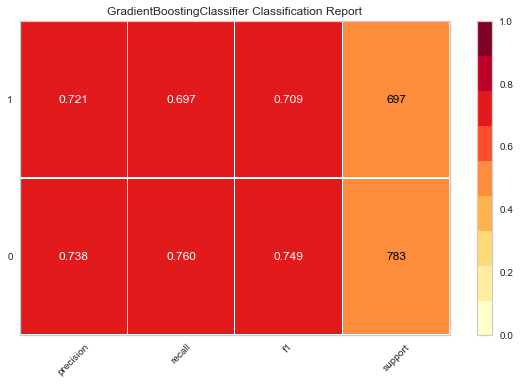

In [79]:
plot_model(model_gbc, plot = 'class_report')

In [98]:
#Score is probability of predicted class.
churn_probability = pred_probability.loc[:,["customer_ID","Score","Label"]]
churn_probability.columns = ["customer_ID","Probability","class_predicted"]
prob=churn_probability.loc[churn_probability["class_predicted"]=='False',["Probability"]]
churn_probability.loc[churn_probability["class_predicted"]=='False',["Probability"]] =1-prob
churn_probability
#churn_probability["class_predicted"]=="False"

,customer_ID,Probability,class_predicted
0,13085.0,0.1334,False
1,13078.0,0.0386,False
2,15362.0,0.5355,True
3,18102.0,0.0279,False
4,12682.0,0.0297,False
...,...,...,...
4928,15925.0,0.4853,False
4929,16483.0,0.7288,True
4930,15163.0,0.4521,False
4931,18204.0,0.2448,False


In [99]:
#Customer ID	Probability of Churn	Churn Class	Total value bought	Recency (R)	Frequency(F)	Monetary(M)	Geography
output = churn_probability
output = output.merge(churn_data, on='customer_ID')
output

,customer_ID,Probability,class_predicted,Recency,Freq,Revenue,price_per_unit,product_top5,product_top5_20,Country,Y_churn
0,13085.0,0.1334,False,33,82,2151.60,3.226220,False,True,United Kingdom,False
1,13078.0,0.0386,False,7,636,19982.06,4.112925,True,True,United Kingdom,False
2,15362.0,0.5355,True,257,40,613.08,3.612000,False,True,United Kingdom,True
3,18102.0,0.0279,False,15,707,409227.74,3.789024,True,True,United Kingdom,False
4,12682.0,0.0297,False,0,719,15296.88,2.915828,True,True,France,False
...,...,...,...,...,...,...,...,...,...,...,...
4928,15925.0,0.4853,False,2,12,207.15,2.895833,True,False,United Kingdom,True
4929,16483.0,0.7288,True,0,19,139.35,4.410526,False,True,United Kingdom,True
4930,15163.0,0.4521,False,0,10,155.00,3.205000,False,True,United Kingdom,False
4931,18204.0,0.2448,False,0,93,549.43,2.223871,False,True,United Kingdom,False


In [100]:
output["CLTV"] = output["Probability"]*output["Revenue"]
output

,customer_ID,Probability,class_predicted,Recency,Freq,Revenue,price_per_unit,product_top5,product_top5_20,Country,Y_churn,CLTV
0,13085.0,0.1334,False,33,82,2151.60,3.226220,False,True,United Kingdom,False,287.023440
1,13078.0,0.0386,False,7,636,19982.06,4.112925,True,True,United Kingdom,False,771.307516
2,15362.0,0.5355,True,257,40,613.08,3.612000,False,True,United Kingdom,True,328.304340
3,18102.0,0.0279,False,15,707,409227.74,3.789024,True,True,United Kingdom,False,11417.453946
4,12682.0,0.0297,False,0,719,15296.88,2.915828,True,True,France,False,454.317336
...,...,...,...,...,...,...,...,...,...,...,...,...
4928,15925.0,0.4853,False,2,12,207.15,2.895833,True,False,United Kingdom,True,100.529895
4929,16483.0,0.7288,True,0,19,139.35,4.410526,False,True,United Kingdom,True,101.558280
4930,15163.0,0.4521,False,0,10,155.00,3.205000,False,True,United Kingdom,False,70.075500
4931,18204.0,0.2448,False,0,93,549.43,2.223871,False,True,United Kingdom,False,134.500464


In [120]:
output["Churn Class"] = 'Low'
output.loc[output["Probability"]>0.6,["Churn Class"]]='Medium'
output.loc[output["Probability"]>0.8,["Churn Class"]]='High'
output

,customer_ID,Probability,class_predicted,Recency,Freq,Revenue,price_per_unit,product_top5,product_top5_20,Country,Y_churn,CLTV,Churn Class
0,17850.0,0.7349,True,110,2738,53464.83,3.189942,True,True,United Kingdom,True,39291.303567,Medium
1,16754.0,0.6455,True,180,156,49288.97,1.458590,False,False,United Kingdom,True,31816.030135,Medium
2,13093.0,0.5288,True,75,1091,52523.85,2.968148,True,True,United Kingdom,True,27774.611880,Low
3,12482.0,0.8149,True,384,202,21941.72,1.366733,False,True,Sweden,True,17880.307628,High
4,13902.0,0.4989,False,440,65,30375.26,0.696154,False,False,Denmark,True,15154.217214,Low
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4928,16252.0,0.6344,True,174,63,-295.09,3.195238,False,False,United Kingdom,True,-187.205096,Medium
4929,15767.0,0.9423,True,449,8,-207.30,6.000000,False,True,United Kingdom,True,-195.338790,High
4930,13091.0,0.1681,False,537,97,-1663.06,1.695567,False,False,United Kingdom,False,-279.560386,Low
4931,14337.0,0.9093,True,539,36,-658.63,2.663333,False,False,United Kingdom,True,-598.892259,High


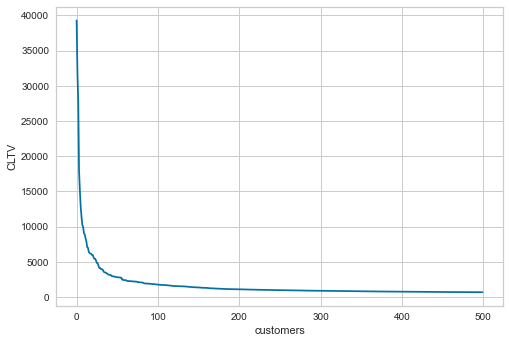

In [115]:
outplot=output.sort_values(by='CLTV',ascending=False).reset_index(drop=True)[0:500]
plt.figure()
plt.plot(outplot.index, outplot.CLTV)
plt.ylabel("CLTV")
plt.xlabel("customers")
plt.show()

In [123]:
output.columns = ["Customer ID","Probability of Churn","class_predicted","Recency","Frequency","Monetary","price_per_unit","product_top5","product_top5_20","Geography","Y_churn","CLTV","Churn Class"]
#output.to_excel("output.xlsx") 
output.loc[:,["Customer ID","Probability of Churn","Churn Class","CLTV","Recency","Frequency","Monetary","Geography"]].to_excel("output.xlsx")